This is a Machine Learning: Linear Regression Project
The Aim of the project is to create a model to predict household prices.

In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from function_file import clean_names

In [119]:
df = pd.read_csv(r"data_in\house_price.csv").rename(columns = clean_names)


In [120]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [121]:
# Check NA
# no NAs
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

Text(0.5, 1.0, 'Price Histogram')

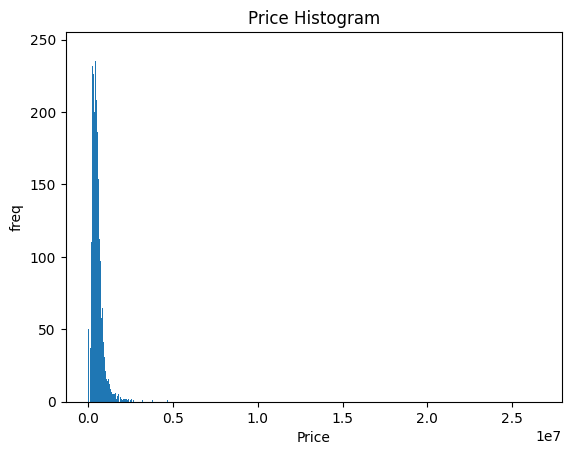

In [122]:
plt.hist(df["price"], bins = 1000)
plt.xlabel('Price')
plt.ylabel('freq')
plt.title('Price Histogram')

{'whiskers': [<matplotlib.lines.Line2D at 0x232932d9cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x232932da210>,
 'boxes': [<matplotlib.lines.Line2D at 0x232932d9a90>],
 'medians': [<matplotlib.lines.Line2D at 0x232932da6c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x232932da960>],
 'means': []}

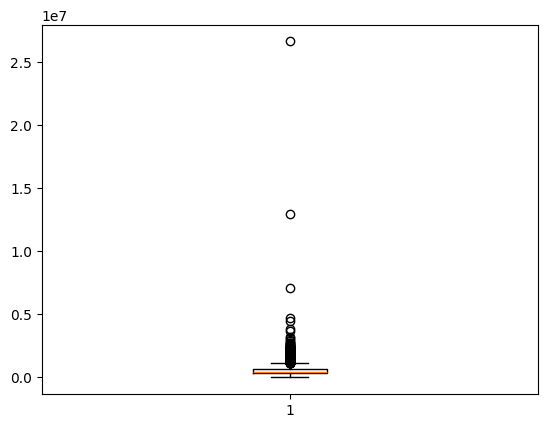

In [123]:
plt.boxplot(df["price"])

In [124]:
print("Minimum Price, ", str(df["price"].idxmin()))
print("Median Price, ", round(df["price"].median()))

Minimum Price,  4354
Median Price,  460943


In [125]:
df_price_trend = df.copy()
df_price_trend["floor_month"] = pd.to_datetime(df_price_trend["date"]).dt.to_period('M')

df_price_trend.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,floor_month
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,2014-05
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,2014-05
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,2014-05
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,2014-05
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,2014-05


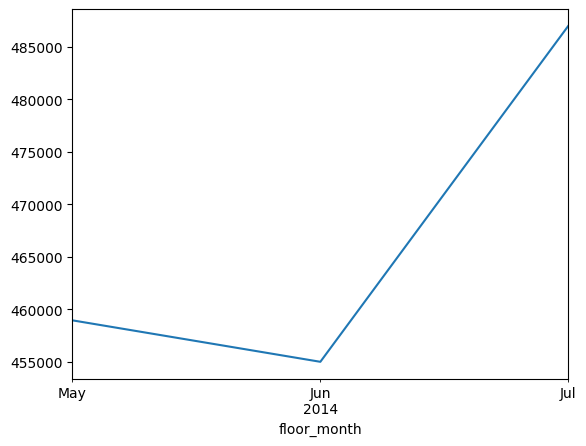

In [126]:
# Median House Price
df_monthly_price = df_price_trend.groupby('floor_month')["price"].median().plot()

In [137]:
clean_df = df.drop(columns = ['date', 'street', 'statezip', 'country']).copy()
clean_df = pd.get_dummies(clean_df, prefix = ["city_"], columns = ["city"])

corr = clean_df.corr()
corr_sort = corr.sort_values(by = ["price"], ascending = False)
corr.style.background_gradient(cmap='coolwarm')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city__Algona,city__Auburn,city__Beaux Arts Village,city__Bellevue,city__Black Diamond,city__Bothell,city__Burien,city__Carnation,city__Clyde Hill,city__Covington,city__Des Moines,city__Duvall,city__Enumclaw,city__Fall City,city__Federal Way,city__Inglewood-Finn Hill,city__Issaquah,city__Kenmore,city__Kent,city__Kirkland,city__Lake Forest Park,city__Maple Valley,city__Medina,city__Mercer Island,city__Milton,city__Newcastle,city__Normandy Park,city__North Bend,city__Pacific,city__Preston,city__Ravensdale,city__Redmond,city__Renton,city__Sammamish,city__SeaTac,city__Seattle,city__Shoreline,city__Skykomish,city__Snoqualmie,city__Snoqualmie Pass,city__Tukwila,city__Vashon,city__Woodinville,city__Yarrow Point
price,1.000000,0.200336,0.327110,0.430410,0.050451,0.151461,0.135648,0.228504,0.034915,0.367570,0.210427,0.021857,-0.028774,-0.020167,-0.089375,0.005049,0.134828,-0.016677,-0.010633,-0.046045,-0.005313,0.066867,-0.044063,-0.049503,-0.025194,-0.033918,0.012220,-0.084757,-0.003321,0.016139,-0.022357,-0.040837,0.036375,-0.016303,-0.055803,0.129795,0.140007,-0.009876,0.017201,-0.005022,-0.028337,-0.020944,0.000388,-0.002624,0.047612,-0.080926,0.047604,-0.043327,0.035642,-0.038682,-0.014453,-0.003477,-0.000705,-0.034427,-0.011219,0.016361,0.033640
sqft_living,0.430410,0.594884,0.761154,1.000000,0.210538,0.344850,0.117616,0.311009,-0.062826,0.876443,0.447206,0.287775,-0.122817,-0.018178,-0.024804,-0.009942,0.148424,-0.012689,0.015891,-0.043017,0.018218,0.075316,-0.034977,-0.038336,0.002213,-0.017620,0.036935,-0.016136,-0.009483,0.068289,-0.003610,-0.033598,0.025677,0.013252,-0.008080,0.099855,0.162803,-0.019151,0.048521,-0.002998,-0.015668,-0.023209,0.003046,0.019194,0.084903,-0.006658,0.142635,-0.038112,-0.232573,-0.062733,-0.020760,0.074974,-0.000602,-0.035822,-0.020647,0.087066,0.010205
sqft_above,0.367570,0.484705,0.689918,0.876443,0.216455,0.522814,0.078911,0.174327,-0.178196,1.000000,-0.038723,0.408535,-0.160426,-0.008367,0.008094,-0.011756,0.106131,-0.001001,0.012879,-0.053222,0.030390,0.039497,-0.020105,-0.041651,0.020440,-0.000303,0.044557,-0.011031,-0.005256,0.070544,-0.004929,-0.013566,0.030537,-0.002952,0.037597,0.090456,0.127431,-0.013845,0.076165,-0.007964,0.006315,-0.012846,0.009138,0.035576,0.124184,0.019192,0.193036,-0.036218,-0.325732,-0.064932,-0.013945,0.113295,-0.005427,-0.037820,-0.007024,0.107353,0.022081
bathrooms,0.327110,0.545920,1.000000,0.761154,0.107837,0.486428,0.076232,0.211960,-0.119994,0.689918,0.298020,0.463498,-0.215886,-0.010978,-0.017430,-0.007730,0.096217,-0.023210,0.029395,-0.067579,0.000853,0.028289,-0.023536,-0.043077,0.013111,-0.040131,0.025449,-0.012262,-0.003026,0.113674,0.005566,-0.005649,0.043793,0.012468,0.034564,0.055266,0.118618,-0.010933,0.038433,-0.011751,0.005241,-0.009337,0.005700,-0.006232,0.065146,-0.012914,0.106008,-0.044382,-0.182717,-0.076141,-0.016108,0.075567,0.011086,-0.050515,-0.031239,0.044429,-0.008406
view,0.228504,0.111028,0.211960,0.311009,0.073907,0.031211,0.360935,1.000000,0.063077,0.174327,0.321602,-0.064465,0.022967,-0.010199,-0.029638,-0.004559,0.049939,-0.013690,-0.026283,0.049267,0.006905,0.036329,-0.030035,0.065190,-0.029680,0.036849,0.002018,-0.015221,-0.004559,-0.039604,-0.020864,-0.054763,-0.019804,0.010576,-0.037325,0.013455,0.107856,-0.006449,-0.026283,0.043254,-0.002782,-0.011174,-0.006449,-0.012071,-0.055251,-0.034896,-0.011847,-0.006983,0.052671,-0.002771,-0.007899,0.006602,-0.004559,-0.017570,0.102412,-0.044144,0.009830
sqft_basement,0.210427,0.334165,0.298020,0.447206,0.034842,-0.255510,0.097501,0.321602,0.200632,-0.038723,1.000000,-0.161675,0.043125,-0.022183,-0.066510,0.001205,0.110874,-0.024474,0.009055,0.009591,-0.018643,0.082931,-0.035240,-0.002186,-0.033377,-0.036004,-0.006118,-0.012994,-0.009916,0.010676,0.001665,-0.044526,-0.003438,0.032986,-0.086608,0.039198,0.101147,-0.014025,-0.040789,0.008572,-0.044246,-0.024302,-

In [129]:
clean_df = df.drop(columns = ['date', 'street', 'statezip', 'country', 'city']).copy()